In [1]:
# import of required packages
import time
import os
import xarray as xr
import json
import numpy as np
import itertools
from tqdm.notebook import trange, tqdm
from earthkit.regrid import interpolate
import zarr
import matplotlib.pyplot as plt
from pathlib import Path
from pychunked_data_view.chunked_data_view import (
    AxisDefinition,
    ChunkedDataViewBuilder,
    ExtractorType,
)
from z3fdb.mapping import (
    FdbSource,
    FdbZarrArray,
    FdbZarrGroup,
    FdbZarrStore,
)

def fmt_ns(nanoseconds):
    if nanoseconds == 0:
        return "0 ns"
    
    if nanoseconds < 0:
        return f"-{format_duration_ns(-nanoseconds)}"
    
    # Define time units in nanoseconds
    units = [
        (86400 * 1_000_000_000, 'd'),  # days
        (3600 * 1_000_000_000, 'h'),   # hours  
        (60 * 1_000_000_000, 'm'),     # minutes
        (1_000_000_000, 's'),          # seconds
        (1_000_000, 'ms'),             # milliseconds
        (1_000, 'μs'),                 # microseconds
        (1, 'ns')                      # nanoseconds
    ]
    
    # For very small durations, show single unit with precision
    if nanoseconds < 1_000:  # < 1 μs
        return f"{nanoseconds} ns"
    elif nanoseconds < 1_000_000:  # < 1 ms
        return f"{nanoseconds / 1_000:.2f} μs"
    elif nanoseconds < 1_000_000_000:  # < 1 s
        return f"{nanoseconds / 1_000_000:.2f} ms"
    
    # For larger durations, show up to 2 significant units
    result_parts = []
    remaining = nanoseconds
    
    for value, unit in units:
        if remaining >= value:
            count = remaining // value
            remaining = remaining % value
            
            if unit in ['d', 'h', 'm']:
                # Show whole numbers for days, hours, minutes
                result_parts.append(f"{count}{unit}")
            else:
                # Show decimals for seconds and below
                if remaining > 0 and len(result_parts) == 0:
                    # If this is the primary unit, show decimal precision
                    decimal_part = remaining / value
                    result_parts.append(f"{count + decimal_part:.2f}{unit}")
                    break
                else:
                    result_parts.append(f"{count}{unit}")
            
            # Stop after 2 units for readability
            if len(result_parts) == 2:
                break
    
    return ' '.join(result_parts)

def plot_timing_distribution(timings_ns, title="Timing Distribution"):

    timings = np.array(timings_ns)
    median_time = np.median(timings)
    
    if median_time < 1000:  # < 1 μs
        values = timings
        unit = "ns"
    elif median_time < 1_000_000:  # < 1 ms
        values = timings / 1000
        unit = "μs"
    elif median_time < 1_000_000_000:  # < 1 s
        values = timings / 1_000_000
        unit = "ms"
    else:
        values = timings / 1_000_000_000
        unit = "s"
    
    # Create histogram
    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel(f'Time ({unit})')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_timing_stats(timings_ns, title="Timing Statistics"):
    """
    Plot statistical measures for timing values.
    
    Args:
        timings_ns (list): List of timing values in nanoseconds
        title (str): Plot title
    """
    timings = np.array(timings_ns)
    
    # Determine best unit
    median_time = np.median(timings)
    if median_time < 1000:
        values = timings
        unit = "ns"
    elif median_time < 1_000_000:
        values = timings / 1000
        unit = "μs"
    elif median_time < 1_000_000_000:
        values = timings / 1_000_000
        unit = "ms"
    else:
        values = timings / 1_000_000_000
        unit = "s"
    
    # Calculate statistics
    stats = {
        'Count': len(values),
        'Mean': np.mean(values),
        'Median': np.median(values),
        'Std Dev': np.std(values),
        'Min': np.min(values),
        'Max': np.max(values),
        '25th %ile': np.percentile(values, 25),
        '75th %ile': np.percentile(values, 75),
        '95th %ile': np.percentile(values, 95),
        '99th %ile': np.percentile(values, 99)
    }
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Box plot
    ax1.boxplot(values, vert=True)
    ax1.set_ylabel(f'Time ({unit})')
    ax1.set_title('Box Plot')
    ax1.grid(True, alpha=0.3)
    
    # Statistics table
    ax2.axis('tight')
    ax2.axis('off')
    
    # Format values for display
    table_data = []
    for key, value in stats.items():
        if key == 'Count':
            formatted_value = f"{int(value):,}"
        else:
            formatted_value = f"{value:.2f}"
        table_data.append([key, formatted_value])
    
    table = ax2.table(cellText=table_data,
                     colLabels=['Statistic', f'Value ({unit})'],
                     cellLoc='left',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    # Style the table
    for i in range(len(table_data) + 1):
        for j in range(2):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor('#40466e')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#f1f1f2' if i % 2 == 0 else 'white')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [2]:
def open_view(fdb_config_path: Path):
    builder = ChunkedDataViewBuilder(fdb_config_path)
    builder.add_part(
        "class=od,"
        "domain=g,"
        "date=-2/-1,"
        "expver=0001,"
        "levtype=sfc,"
        "param=167,"
        "step=0/1/2/3/4/5/6/7/8/9/10/11/12/13/14/15/16/17/18/19/20/21/22/23/24/25/26/27/28/29/30/31/32/33/34/35/36/37/38/39/40/41/42/43/44/45/46/47/48/49/50/51/52/53/54/55/56/57/58/59/60/61/62/63/64/65/66/67/68/69/70/71/72/73/74/75/76/77/78/79/80/81/82/83/84/85/86/87/88/89/90/93/96/99/102/105/108/111/114/117/120/123/126/129/132/135/138/141/144/150/156/162/168/174/180/186/192/198/204/210/216/222/228/234/240/246/252/258/264/270/276/282/288/294/300/306/312/318/324/330/336/342/348/354/360,"
        "stream=oper,"
        "time=0000/1200,"
        "type=fc",
        [AxisDefinition(["date", "time"], True), AxisDefinition(["step"], True)],
        ExtractorType.GRIB,
    )
    view = builder.build()
    mapping = FdbZarrStore(
        FdbZarrGroup(
            children=[
                FdbZarrArray(
                    name="data",
                    datasource=FdbSource(view),
                )
            ]
        )
    )
    return zarr.open_group(mapping, mode="r", zarr_format=3, use_consolidated=False)

In [3]:
# Read 4 forecasts from fdb and time access
def create_zarr_group():
    os.environ["FDB_HOME"] = "/home/fdbprod/"
    fdb_prod_cfg=Path("/home/fdbprod/etc/fdb/config.yaml")
    return open_view(fdb_prod_cfg)

# This is the whole zarr group
group = create_zarr_group()
# data array with the 0000/1200 forcasts of the last two days
data = group["data"]

shape = data.shape
indexes = list(itertools.product(*[range(0, x) for x in shape[:-1]]))

wc_times = []
cpu_times = []
tot_wc_t0 = time.perf_counter_ns()
tot_cpu_t0 = time.process_time_ns()
for x in tqdm(indexes, unit='field'):
    wc_t0 = time.perf_counter_ns()
    cpu_t0 = time.process_time_ns()
    _ = data[*x]
    wc = time.perf_counter_ns() - wc_t0
    cpu = time.process_time_ns() - cpu_t0
    wc_times.append(wc)
    cpu_times.append(cpu)
tot_wc = time.perf_counter_ns() - tot_wc_t0
tot_cpu = time.process_time_ns() - tot_cpu_t0
print(f"Wall Clock time spent: {fmt_ns(tot_wc)}")
print(f"System time spent: {fmt_ns(tot_cpu)}")
print(f"Time spent waiting (e.g. IO): {fmt_ns(tot_wc - tot_cpu)}")

  0%|          | 0/580 [00:00<?, ?field/s]

Wall Clock time spent: 36.49s
System time spent: 35.36s
Time spent waiting (e.g. IO): 1.13s


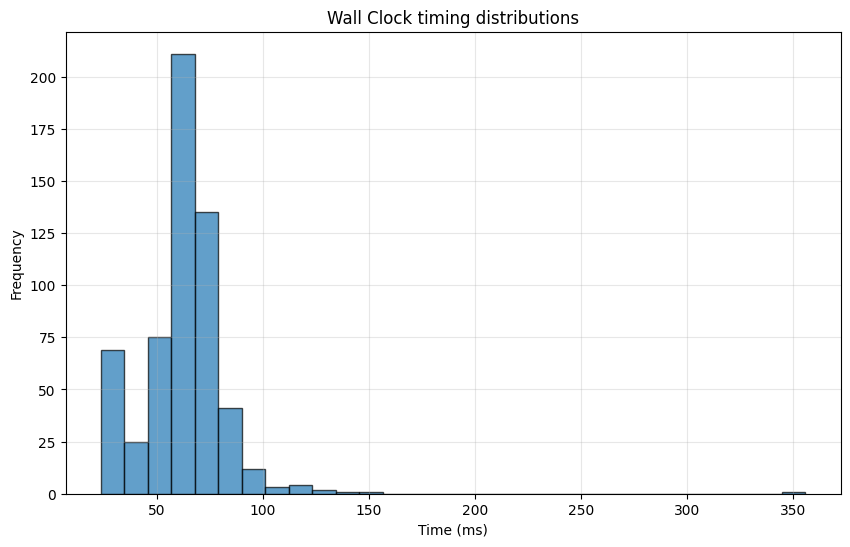

In [4]:
plot_timing_distribution(wc_times, "Wall Clock timing distributions")

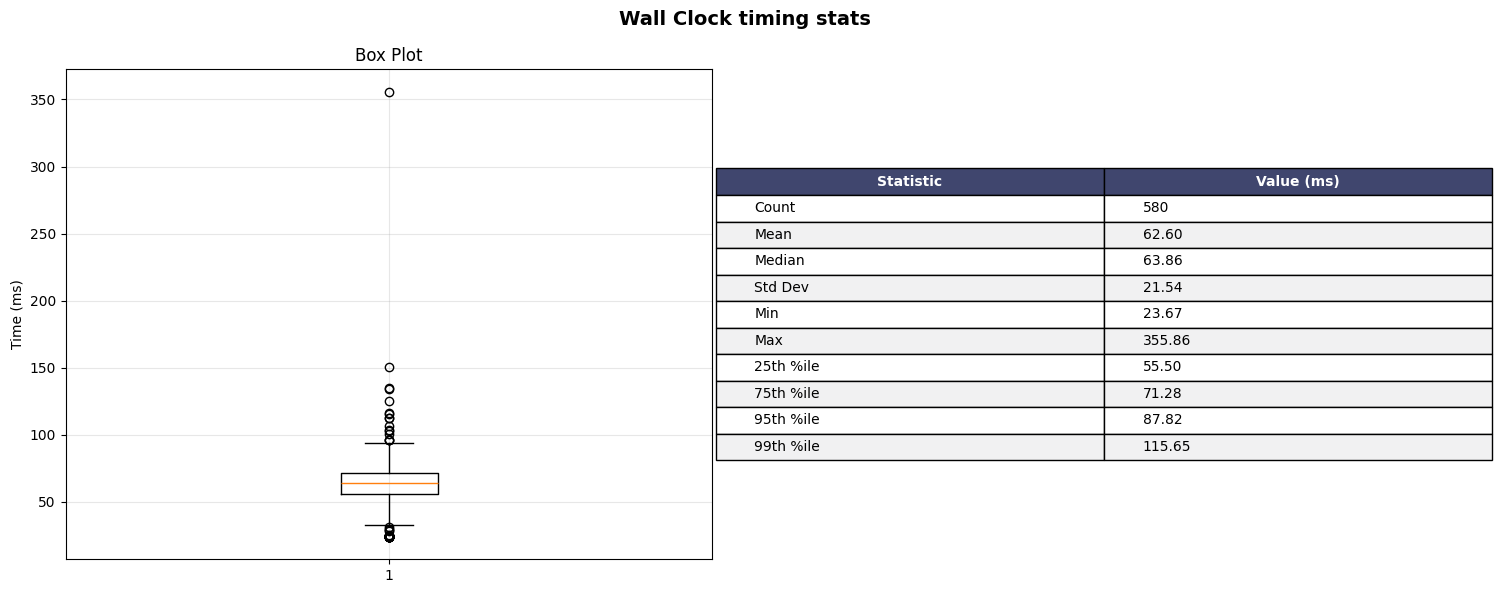

In [5]:
plot_timing_stats(wc_times, "Wall Clock timing stats")

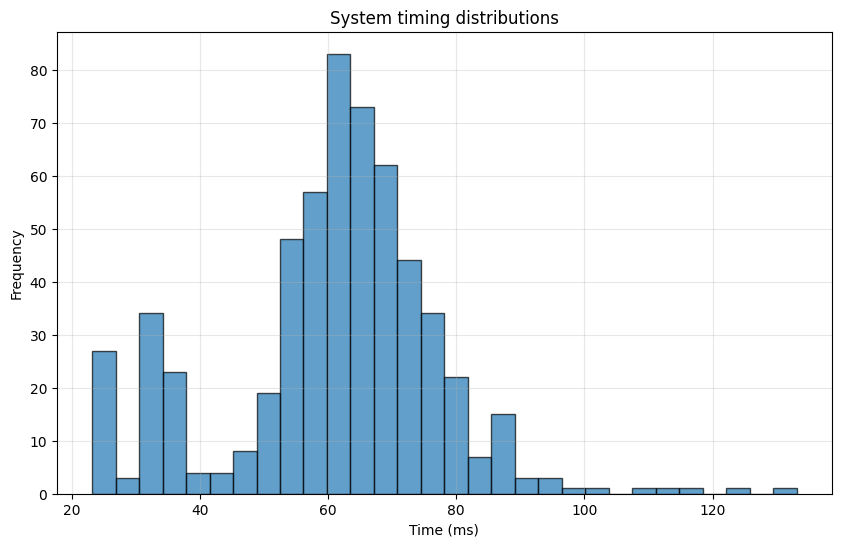

In [6]:
plot_timing_distribution(cpu_times, "System timing distributions")

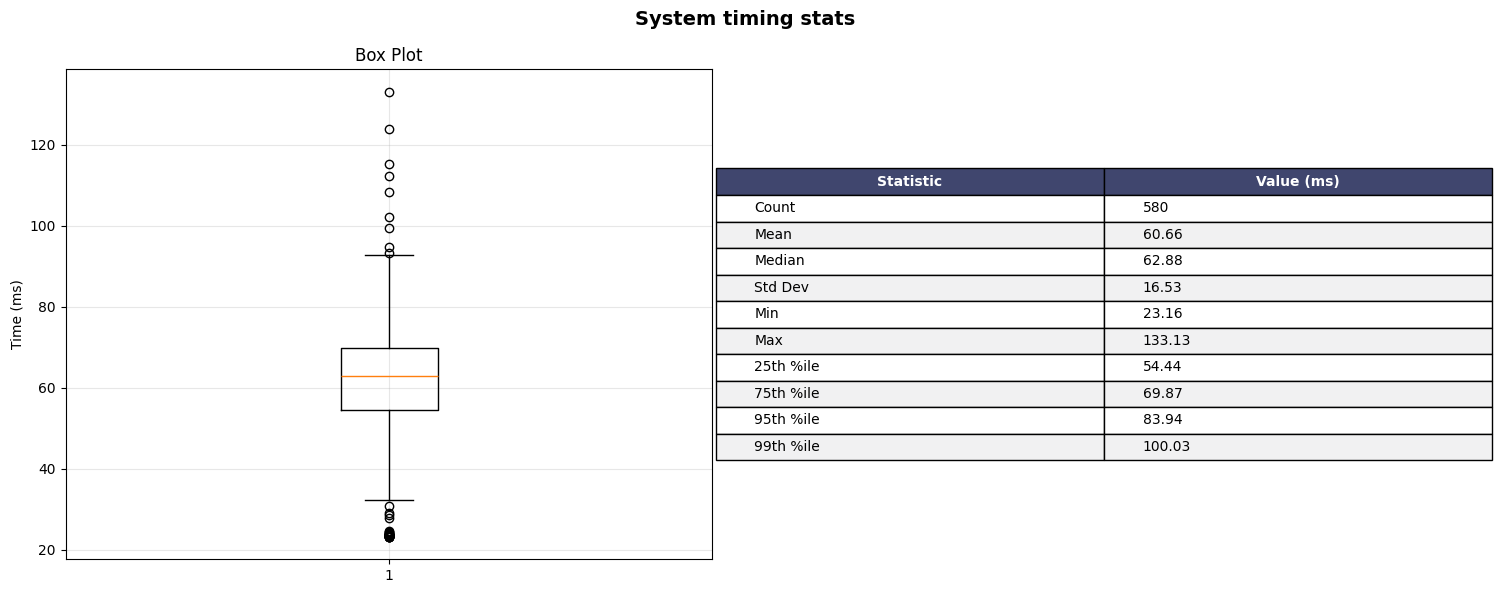

In [7]:
plot_timing_stats(cpu_times, "System timing stats")

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean

def worldmap(arr, step, **kwargs):
    var = interpolate(arr[0,step], {"grid": "O1280"}, {"grid": [1,1]})
    projection = ccrs.PlateCarree(central_longitude=180)
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    ax.imshow(var, extent=xlims + ylims, origin="upper", **kwargs)
    ax.add_feature(cf.COASTLINE, linewidth=0.3)
    ax.add_feature(cf.BORDERS, linewidth=0.1)

In [9]:
# Demonstrate live access from fdb, moving the slider pulls fields from fdb every time
def widget_animate_worldmap(data, num_steps=None, **kwargs):
    """
    Widget-based animation (smoothest, requires ipywidgets)
    """
    try:
        from ipywidgets import interact, IntSlider
        import ipywidgets as widgets
    except ImportError:
        print("ipywidgets not available. Use: pip install ipywidgets")
        return
    
    if num_steps is None:
        num_steps = data.shape[1]
    
    def show_step(step):
        worldmap(data, step, **kwargs)
        plt.title(f'Step: {step}')
        plt.show()
    
    # Create auto-playing slider
    play_widget = widgets.Play(value=0, min=0, max=num_steps-1, step=1, interval=150)
    slider = widgets.IntSlider(value=0, min=0, max=num_steps-1)
    widgets.jslink((play_widget, 'value'), (slider, 'value'))
    
    interact(show_step, step=slider)
    display(widgets.HBox([play_widget, slider]))

widget_animate_worldmap(data, num_steps=shape[1])

interactive(children=(IntSlider(value=0, description='step', max=144), Output()), _dom_classes=('widget-intera…